<a name= 'task2'></a>
# Task 2

<a name='task2a'></a>
## Task 2 a. Train a convolutional neural network CIFAR-10</h2>

### Imports for task 2

In [48]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image

One important aspect of these deep learning models is that they can automatically leran hierarchical feature representations. This means that features computed by the first layer are general and can be reused in different problem domains, while features computed by the last layer are specific and depend on the chosen dataset and task.


In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data preprocessing and Augmentation


Before training, we first preprocessed the CIFAR-10 images and applied augmentation to improve model generalization. Data augmentation creates realistic variations of training images (Shorten et. al., 2019). In this task, the following transformations are applied to each training image:

<li>Resize to <b>96 x 96</b>: This higher resolution matches the input size expected by our pre-trained model MobileNetV2.</li><br>
<li>Random horizontal flip: Mirrors images randomly (an airplane is still an airplane when flipped).</li> <br>
<li>Random perspective transform and affine transforms: Applies slight geometric distortions (changes in perspective, shear, scale) to simulate different viewpoints. This makes the model robust to viewpoint changes. </li><br>
<li>Color jitter and sharpness adjustment: Randomly alters brightness/contrast and sharpness. This simulates different lightning conditions and camera focus, improving the networks tolerance to variations. </li><br>
<li>Tensor conversion and normalization: Images are converted to PyTorch tensors and normalized channel-wise using CIFAR-10 mean and st.deviation. </li>

In [50]:
#1. Prepare data
transform_train = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

The CIFAR-10 dataset consist of 60 000 images across 10 classes. 50 000 training images and 10 000 test images. In this task we simplify the classification to a binary problem; <i>distinguishing the airplane-class (labeled 0 in CIFAR-10) from all the other classes</i>. This means we relabel each image as 1 if it is an airplane, and 0 otherwise. This creates two classes: 'airplane' and 'not airplane'. The 'airplane' class contains of 5 000 training images, while 'not airplane' contains 45 000 training images.

In [51]:
def relabel_airplane_binary(dataset):
    dataset.targets = [1 if label == 0 else 0 for label in dataset.targets]
    return dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_dataset = relabel_airplane_binary(train_dataset)
test_dataset = relabel_airplane_binary(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

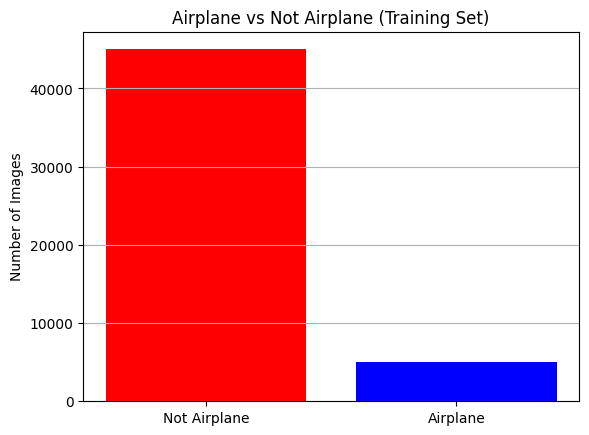

In [52]:
# Count labels
labels = train_dataset.targets
classes, counts = np.unique(labels, return_counts=True)

# Plot
plt.bar(['Not Airplane', 'Airplane'], counts, color=['red', 'blue'])
plt.title('Airplane vs Not Airplane (Training Set)')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.show()

<i>Class imbalance in the training set: 'Airplane' vs 'Not Airplane'. Only 5 000 of 50 000 training images are airplanes, while 45 000 images are other objects (animals, vwhicles, etc.), making accuracy alone misleading. 


This imbalance poses the challenge that the model could naively predict every image as 'Not Airplane' and be correct 90% of the time, eventhough it failed to predict any airplanes. In fact, accuracy can be a misleading metric on imbalanced data, as it may reflect the dominant class frequently (kilde). To address this, we need to ensure our model pays attention to the minority class. We will do so by using a weighted loss function that penalizes errors on airplanes more than errors on non-airplanes. This way, mistakes in the rare class count more heavily, prompting the model to focus on detecting airplanes (kilde). 


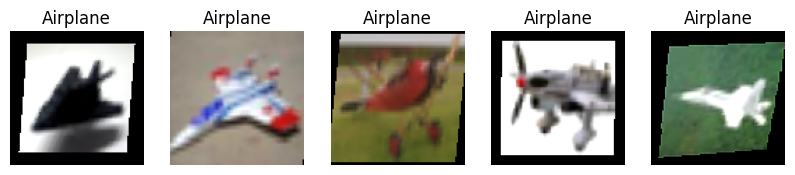

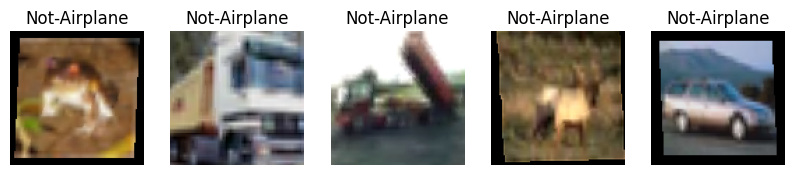

In [53]:
def unnormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
    return img * std + mean

# Visualize N images of one class
def show_images(dataset, label=1, n=5, title='Airplane' if 1 else 'Not-Airplane'):
    shown = 0
    plt.figure(figsize=(n*2, 2))
    i = 0
    while shown < n and i < len(dataset):
        img, lbl = dataset[i]
        if lbl == label:
            img = unnormalize(img)
            img = img.permute(1, 2, 0).numpy()
            plt.subplot(1, n, shown+1)
            plt.imshow(np.clip(img, 0, 1))
            plt.axis('off')
            plt.title(title)
            shown += 1
        i += 1
    plt.show()


show_images(train_dataset, label=1, title='Airplane')
show_images(train_dataset, label=0, title='Not-Airplane')

<i>This visualizes the two classes 'Airplane' & 'Not Airplane' and their different images. </i>

### MobileNetV2


In this task we have chosen to use MobileNetV2, a lightweight CNN originally trained on ImageNet, as our base model. MobileNetV2 is designed for efficiency, while also achieving high accuracy(kilde). By using a model pre-trained on more than one million images, we expect its early layers to already recognize basic image feautres that will help in identifying airplanes. We then only need to customize the final layers for our two-class task.

In [54]:
#Load MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1]=nn.Linear(model.last_channel, 1)
model = model.to(device)

/Users/olesander/Documents/GitHub/INFO284/sentiment_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/olesander/Documents/GitHub/INFO284/sentiment_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Cross-entropy with logits

In [72]:
positive_weight = torch.tensor([9.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=positive_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

<a name='training_task3'></a>
### Training of the model

In [56]:
#Training function with metric tracking and plotting
def train_model(model, train_loader, test_loader, epochs=5, name=None):
    train_acc, test_acc = [], []
    train_prec, test_prec = [], []
    train_rec, test_rec = [], []
    train_f1, test_f1 = [], []
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        model.train()
        y_true, y_pred = [], []
        total_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_acc.append(np.mean(np.array(y_true) == np.array(y_pred)) * 100)
        train_prec.append(precision_score(y_true, y_pred, zero_division=0))
        train_rec.append(recall_score(y_true, y_pred, zero_division=0))
        train_f1.append(f1_score(y_true, y_pred, zero_division=0))
        train_loss.append(total_loss/len(train_loader))

        # Validation
        model.eval()
        y_true, y_pred = [], []
        total_val_loss = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(imgs)
                loss=criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        test_acc.append(np.mean(np.array(y_true) == np.array(y_pred)) * 100)
        test_prec.append(precision_score(y_true, y_pred, zero_division=0))
        test_rec.append(recall_score(y_true, y_pred, zero_division=0))
        test_f1.append(f1_score(y_true, y_pred, zero_division=0))
        test_loss.append(total_val_loss/len(test_loader))

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.2f}% | Test Acc: {test_acc[-1]:.2f}% | F1: {test_f1[-1]:.4f}% | Loss: {test_loss[-1]:.4f}%")
        scheduler.step()

    if name:
        df = pd.DataFrame({
            'epoch':list(range(1, epochs + 1)),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_prec': train_prec,
            'test_prec': test_prec,
            'train_rec': train_rec,
            'test_rec': test_rec,
            'train_f1': train_f1,
            'test_f1': test_f1
        })
        df.to_csv(f'{name}_metrics.csv', index=False)
        torch.save(model.state_dict(), f'{name}_model.pth')
            
#Train the MobileNetV2 model with 10 epochs
train_model(model, train_loader, test_loader, 10, 'Finish')

Epoch 1/10 - Train Acc: 89.98% | Test Acc: 92.71% | F1: 0.7214% | Loss: 0.3119%
Epoch 2/10 - Train Acc: 93.22% | Test Acc: 95.71% | F1: 0.8144% | Loss: 0.2297%
Epoch 3/10 - Train Acc: 93.80% | Test Acc: 94.91% | F1: 0.7904% | Loss: 0.2220%
Epoch 4/10 - Train Acc: 94.66% | Test Acc: 96.32% | F1: 0.8393% | Loss: 0.1895%
Epoch 5/10 - Train Acc: 94.81% | Test Acc: 96.07% | F1: 0.8273% | Loss: 0.2266%
Epoch 6/10 - Train Acc: 95.26% | Test Acc: 97.09% | F1: 0.8653% | Loss: 0.2105%
Epoch 7/10 - Train Acc: 95.70% | Test Acc: 96.84% | F1: 0.8565% | Loss: 0.2269%
Epoch 8/10 - Train Acc: 95.80% | Test Acc: 97.31% | F1: 0.8735% | Loss: 0.1992%
Epoch 9/10 - Train Acc: 96.22% | Test Acc: 96.83% | F1: 0.8538% | Loss: 0.2639%
Epoch 10/10 - Train Acc: 96.31% | Test Acc: 96.25% | F1: 0.8366% | Loss: 0.1847%


<a name='graphs'></a>
### Graphs

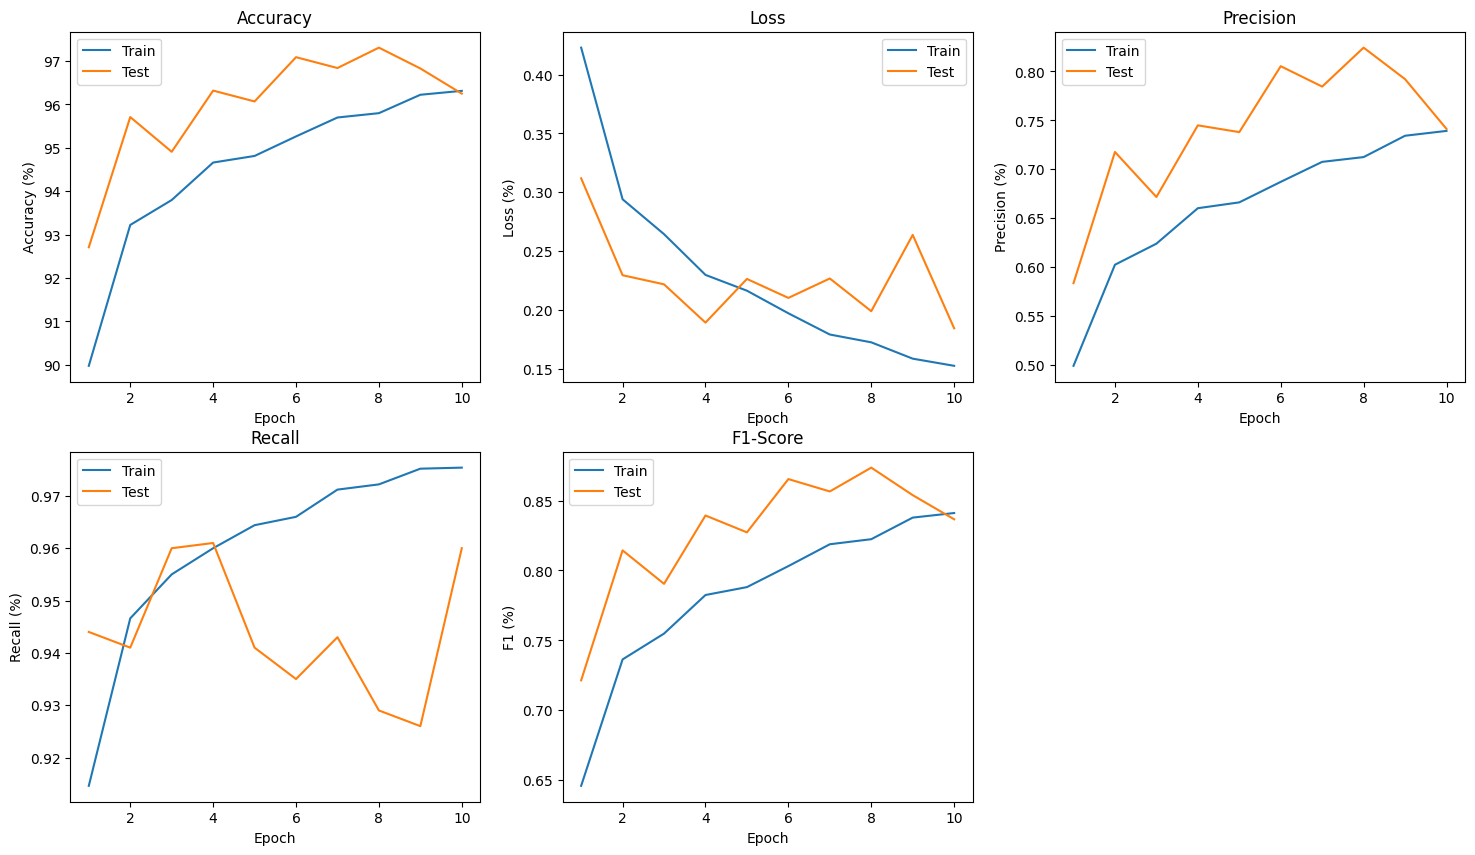

In [71]:
# Plot metrics
df = pd.read_csv('Finish_metrics.csv')

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(df['epoch'], df['train_acc'], label='Train')
plt.plot(df['epoch'], df['test_acc'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()

plt.subplot(2, 3, 2)
plt.plot(df['epoch'], df['train_loss'], label='Train')
plt.plot(df['epoch'], df['test_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss (%)'); plt.legend()

plt.subplot(2, 3, 3)
plt.plot(df['epoch'], df['train_prec'], label='Train')
plt.plot(df['epoch'], df['test_prec'], label='Test')
plt.title('Precision')
plt.xlabel('Epoch'); plt.ylabel('Precision (%)'); plt.legend()

plt.subplot(2, 3, 4)
plt.plot(df['epoch'], df['train_rec'], label='Train')
plt.plot(df['epoch'], df['test_rec'], label='Test')
plt.title('Recall')
plt.xlabel('Epoch'); plt.ylabel('Recall (%)'); plt.legend()

plt.subplot(2, 3, 5)
plt.plot(df['epoch'], df['train_f1'], label='Train')
plt.plot(df['epoch'], df['test_f1'], label='Test')
plt.title('F1-Score')
plt.xlabel('Epoch'); plt.ylabel('F1 (%)'); plt.legend()


plt.show()

3. Track More Than Accuracy
Use metrics like:

Precision (how many predicted airplanes were correct)

Recall (how many actual airplanes you caught)

F1-score (balance between precision & recall)

<a name='task2b'></a>
## Task 2 b. Predicting images

With the trained model, we can use it to predict new 'unseen' images. We define a helper function that loads and image file, applies the same preprocessing as our training data, and then runs our trained network to get a prediction. We also attach a confidence score for the prediction. 


In [73]:
# Image prediction and visualization function

def predict_image(image_path, model_path='Finish_model.pth'):
    # Load trained MobileNetV2
    model = models.mobilenet_v2(pretrained=False)
    model.classifier[1] = torch.nn.Linear(model.last_channel, 1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load and preprocess new image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform_test(image).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output).item()

    # Format output
    label = "Airplane" if prob > 0.5 else "Not Airplane"
    confidence = prob * 100 if prob > 0.5 else (1 - prob) * 100

    # Visualize
    plt.imshow(image)
    plt.axis()
    plt.title(f"{label} ({confidence:.2f}% confidence)", fontsize=14, color='navy')
    plt.show()

    return label, confidence

We load the trained model from the saved weights. The image is opened with PIL and cinverted to RGB, then fed through the same normalization pipeline as our training images. The model's output probability represents the confidence that the image is an airplane. Using this fucntion, we tested our model on a variety of images:


#### Example 1: Dog


/Users/olesander/Documents/GitHub/INFO284/sentiment_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/olesander/Documents/GitHub/INFO284/sentiment_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


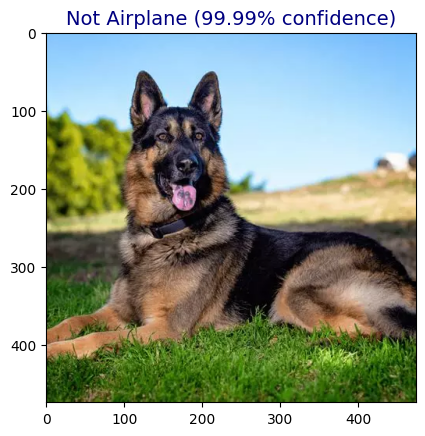

('Not Airplane', 99.98515000479529)

In [74]:
predict_image('my_dog.jpg')

An image of a dog was predicted as 'Not Airplane' with over 99% confidence. <b>Good</b>, as the dog is indeed not an airplane. 


#### Example 2: Frog


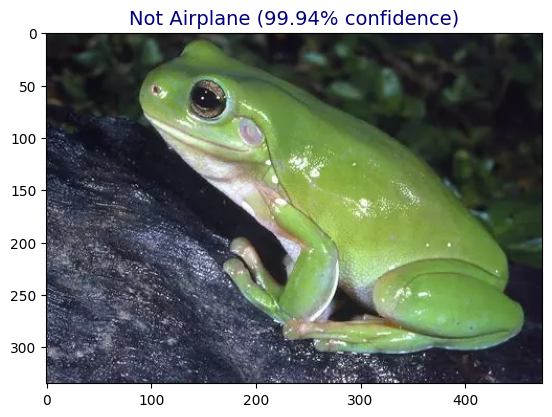

('Not Airplane', 99.9422014283482)

In [75]:
predict_image('frog.webp')

An image of a frog predicted 'Not Airplane' with over 99% confidence. Same as the dog, <b><i>very</i> good</b>.


#### Example 3: Plane with mountain background


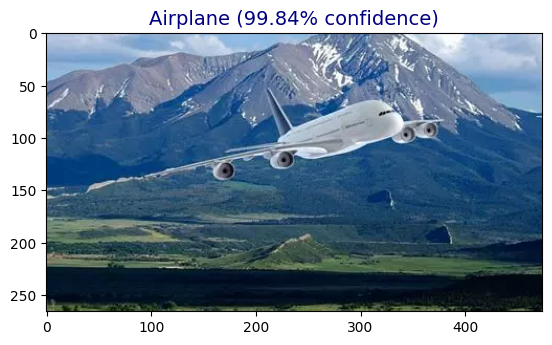

('Airplane', 99.84490871429443)

In [76]:
predict_image('airplane_1.webp')

An image of an airplane flying in front of a mountain range was predicted 'Airplane' with 99% confidence. Proving that the model can successfully recognize airplanes. 


#### Example 4: Bombardino Crocodilo


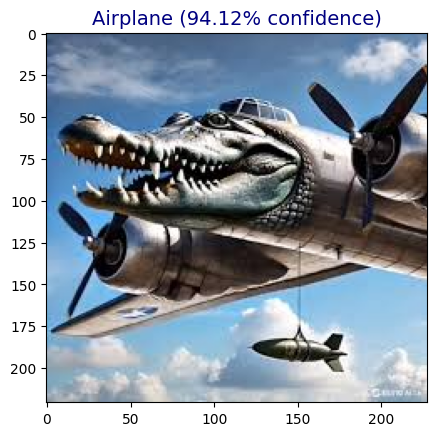

('Airplane', 94.11544799804688)

In [77]:
predict_image('croc_bomb.jpeg')

We even tried an image of the popular internet 'brainrot' meme, Bombardino Crocodilo. This AI Crocodile-faced airplane was predicted as an airplane with 94% confidence. 


## Conclusion

In conclusion, we successfully trained a convolutional neural network to detect airplanes in the CIFAR-10 dataset using transfer learning. By employing data augmentation and a pre-trained MobileNetV2 model, we achievced robust performance with 10 training epochs. The model reached approximately 96% accuracy on the test set and was also able to correctly identify roughly 85-90% of airplanes images (high recall), while also showing high precision mislabeling very few non-airplanes as airplanes. This was accomplished by addressing the big class imbalance and applying a weighted loss to make the model focus on the minority airplane-class. We also tracked the F1-score during training to ensure balanced improvements. The result is an image classifier that reliably distinguishes airplanes form the other objects in the images. 
